## Predicting total energies and enthalpies of formation of metal-nonmetal compounds by linear regression 

Here, we want to study the accuracy and time used to predict variable dataset sizes using the featurizations and algorithms used in [Deml et al paper](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.93.085142)

Referred to `matminer_examples/notebooks/machine-learning/predicting-formation-enthalpy-from-composition.ipynb `

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import pymatgen as pmg
import matplotlib.pyplot as plt

from matminer.utils.conversions import str_to_composition, composition_to_oxidcomposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf

from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lars, LarsCV, LassoLars, lars_path
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict, KFold, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from matplotlib.colors import LogNorm

from pymatgen import MPRester

### Loading pickle file

In [2]:
data = pd.read_pickle('./deml_featurized_data.pkl')

### Linear Model: Stepwise Linear Regression 

Remove outliers

In [3]:
original_count = len(data)
data = data[np.logical_and(data['total_energy'] >= -20, data['total_energy'] <= 5)].reset_index(drop=True)
data = data[np.logical_and(data['delta_e'] >= -20, data['delta_e'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/2220 entries


In [4]:
data.fillna(value=0, inplace=True)
data.isnull().any().any()

False

Storing formation enthalpy data for later use

In [5]:
orig_delta_e = data['delta_e']

Shuffling data and specifying data to be learnt

In [6]:
data = shuffle(data)

In [7]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['total_energy']

Each dataset is randomly divided into three groups: 
- 70% for training the model
- 15% for preliminary assessment (validation) of model's predictive ability
- 15% for independent assessment (testing) of model's predictive ability

In [8]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

### Part 3: Quantifying performance of LARS model with different number of candidate descriptors used

Implementation of stepwise linear regression where terms (candidate descriptors) from a linear model are sequentially added or removed according to their effective significance probabilities. In the paper, this approach was implemented in [JMP](https://www.jmp.com/en_us/software/predictive-analytics-software.html). Here, we use recursive feature elimination to assign weights to features and remove features with low weightage.




10-fold cross validation was used within the training set to quantify performance of model

In [9]:
kfold = KFold(10, shuffle=True)

Number of terms (candidate descriptors) to be used

In [10]:
num_features = range(10, data.shape[1], 25)

Initializing mean absolute error, mean squared error and R2 score

In [11]:
score_train = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_val = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}
score_test = {"r2_score": [], "mean_absolute_error": [], "mean_squared_error": []}

Training the Least Angle Regression (LARS) model with variable number of features used and quantifying the performance. 

In [12]:
for i in num_features:
    selector = Lars(n_nonzero_coefs=i, eps=1e-6)
    selector = selector.fit(x_train, y_train)
    cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
    cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
    cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        score_train[scorer].append(getattr(metrics,scorer)(y_train, cv_train))
        score_val[scorer].append(getattr(metrics,scorer)(y_val, cv_val))
        score_test[scorer].append(getattr(metrics,scorer)(y_test, cv_test))

Plot the model performance when number of terms (candidate descriptors) is changed.

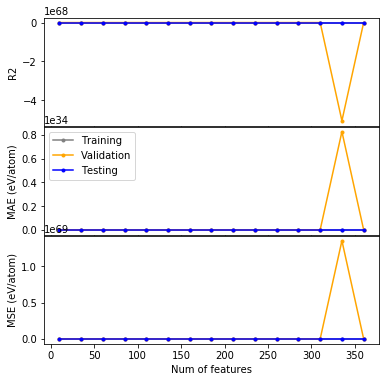

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax3.set_xlabel("Num of features")
ax1.set_ylabel("R2")
ax2.set_ylabel("MAE (eV/atom)")
ax3.set_ylabel("MSE (eV/atom)")

ax1.plot(num_features, score_train['r2_score'], c='grey', marker='.', label='Training')
ax1.plot(num_features, score_val['r2_score'], c='orange', marker='.', label='Validation')
ax1.plot(num_features, score_test['r2_score'], c='blue', marker='.', label='Testing')

ax2.plot(num_features, score_train['mean_absolute_error'], c='grey', marker='.', label='Training')
ax2.plot(num_features, score_val['mean_absolute_error'], c='orange', marker='.', label='Validation')
ax2.plot(num_features, score_test['mean_absolute_error'], c='blue', marker='.', label='Testing')

ax3.plot(num_features, score_train['mean_squared_error'], c='grey', marker='.', label='Training')
ax3.plot(num_features, score_val['mean_squared_error'], c='orange', marker='.', label='Validation')
ax3.plot(num_features, score_test['mean_squared_error'], c='blue', marker='.', label='Testing')

ax2.legend()

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.01)

_Best_: Using 10 terms. (INTRIGUING)

Prediction is way better using `energy_per_atom` instead of `energy`.

### Choose to use between Lars or LassoLars model for total energy prediction. 

In [14]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
#     selector = Lars(n_nonzero_coefs=10)
    selector = LassoLars(alpha=0.00000001)
    selector = selector.fit(x_train, y_train)

In [15]:
cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 270 iterations, i.e. alpha=3.703e-05, with an active set of 112 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 270 iterations, i.e. alpha=3.703e-05, with an active set of 112 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 270 iterations, i.e. alpha=3.703e-05, with an active set of 112 regressors, and the smallest cholesky pivot

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 147 iterations, i.e. alpha=1.689e-04, with an active set of 71 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 148 iterations, i.e. alpha=1.665e-04, with an active set of 72 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 152 iterations, i.e. alpha=1.658e-04, with an active set of 74 regressors, and the smallest cholesky pivot el

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=8.409e-04, with an active set of 36 regressors, and the smallest cholesky pivot element being 7.671e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=4.739e-04, with an active set of 48 regressors, and the smallest cholesky pivot element being 7.814e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 88 iterations, alpha=4.512e-04, previous alpha=4.507e-04, w

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 320 iterations, alpha=4.325e-05, previous alpha=4.322e-05, with an active set of 123 regressors.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.243e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 3.799e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.237e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 3.650e-08. Reduce

Plot the predictions

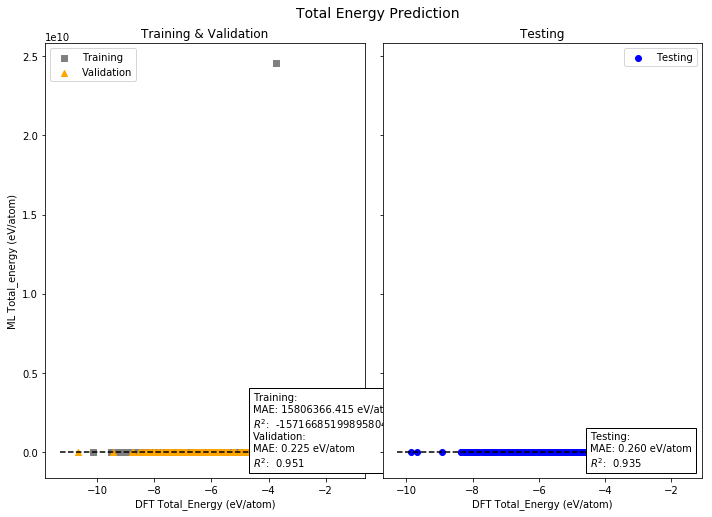

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Total Energy Prediction', fontsize=14, x=0.53, y=1.02)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Total_Energy (eV/atom)')
ax1.set_ylabel('ML Total_energy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Total_Energy (eV/atom)')

fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

### Prediction of formation enthalpy

In [17]:
ML_delta_e = pd.Series(index=np.arange(data.shape[0]))

In [18]:
ML_total_energy = selector.predict(x)

Importing fitted elemental phase reference energies, $\mu^{FERE}$ from `matminer.utils.data_files.deml_elementdata`

In [19]:
from matminer.utils.data_files.deml_elementdata import mus_fere

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$

In [20]:
for i in range(data.shape[0]):
    fere = (float(data['composition_obj'][i][str(j)])/data['composition_obj'][i].num_atoms*mus_fere[str(j)] for j in (data['composition_obj'][i]))
    fere = sum(fere)
    ML_delta_e[i] = ML_total_energy[i] - fere

Partitioning both ML and DFT formation enthalpy data into training, validation and testing sets.

In [21]:
DFT_delta_e = orig_delta_e
ML_delta_e, DFT_delta_e = shuffle(ML_delta_e, DFT_delta_e)
dft_train, dft_val, dft_test = DFT_delta_e[:int(n*0.7)], DFT_delta_e[int(n*0.7):int(n*0.85)], DFT_delta_e[int(n*0.85):]
ml_train, ml_val, ml_test = ML_delta_e[:int(n*0.7)], ML_delta_e[int(n*0.7):int(n*0.85)], ML_delta_e[int(n*0.85):]

Plot the prediction of formation enthalpy

In [22]:
mae_train = metrics.mean_absolute_error(ml_train, dft_train)
mae_val = metrics.mean_absolute_error(ml_val, dft_val)
mae_test = metrics.mean_absolute_error(ml_test, dft_test)

r2_train = metrics.r2_score(ml_train, dft_train)
r2_val = metrics.r2_score(ml_val, dft_val)
r2_test = metrics.r2_score(ml_test, dft_test)

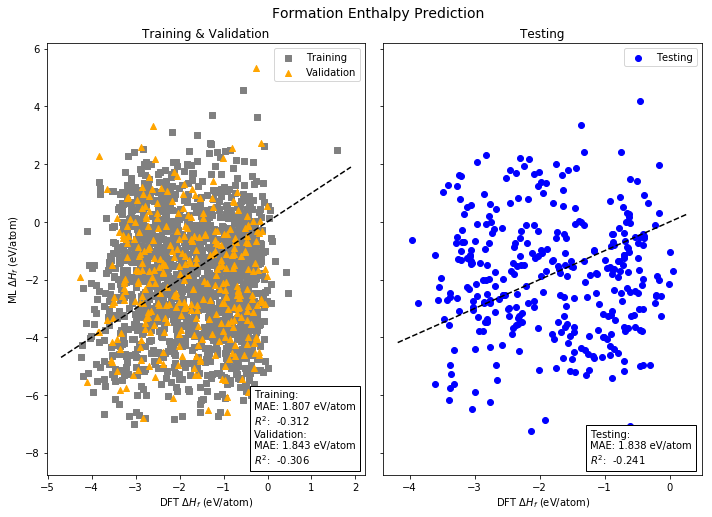

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Formation Enthalpy Prediction', fontsize=14, x=0.53, y=1.02)

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax1.set_ylabel('ML $\Delta H_f$ (eV/atom)')
ax1.scatter(dft_train, ml_train, c='grey', marker='s', label='Training')
ax1.scatter(dft_val, ml_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax2.scatter(dft_test, ml_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.legend()

fig.set_size_inches(10, 7)
fig.tight_layout()

***Large mean absolute error as compared to ~80 meV/atom in paper.***

## PREDICTION OF FORMATION ENTHALPY DIRECTLY (LARS/LassoLars) 

In [24]:
data = shuffle(data)

In [25]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['delta_e']

Dividing datasets into training, validation and testing sets

In [26]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Training LARS / LassoLars model

In [27]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
#     selector = Lars(n_nonzero_coefs=10)
    selector = LassoLars(alpha=0.00000001)
    selector = selector.fit(x_train, y_train)

In [28]:
cv_train = cross_val_predict(selector, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(selector, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(selector, x_test, y_test, cv=kfold)

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 81 iterations, i.e. alpha=1.774e-04, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 280 iterations, i.e. alpha=3.719e-05, with an active set of 116 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 283 iterations, i.e. alpha=3.714e-05, with an active set of 117 regressors, and the smallest cholesky pivot e

Plot the predictions

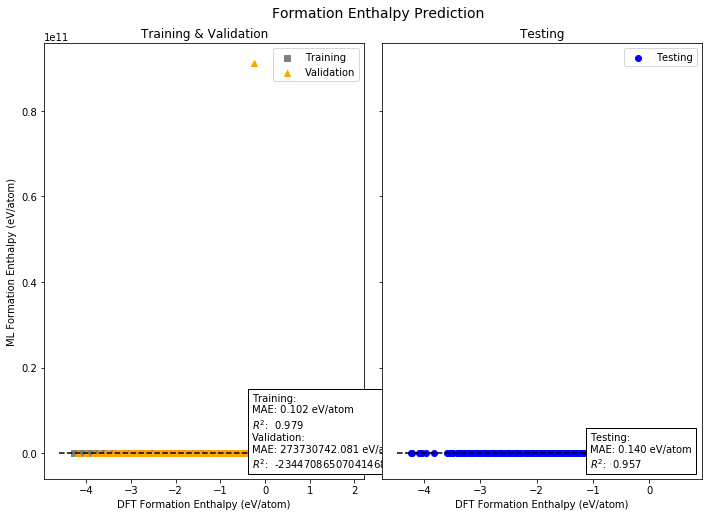

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Formation Enthalpy Prediction', fontsize=14, x=0.53, y=1.02)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Formation Enthalpy (eV/atom)')
ax1.set_ylabel('ML Formation Enthalpy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Formation Enthalpy (eV/atom)')

fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

# Using RandomForestRegressor model 

We're trying to study if the bad prediction using Least Angle Regression linear model is due to the lack of nonlinear features.

In [30]:
data = shuffle(data)

In [31]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['total_energy']

Dividing datasets into training, validation and testing sets

In [32]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Using GridSearchCV to find the optimal number of features. 

In [33]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(10, data.shape[1], 50)),
                     scoring='neg_mean_squared_error', 
                     cv=kfold)

In [34]:
%%time
model.fit(x_train, y_train)

CPU times: user 11min 24s, sys: 6.02 s, total: 11min 30s
Wall time: 11min 47s


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(10, 370, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Plot RMSE as a function of features used

Text(0,0.5,'RMSE (eV/atom)')

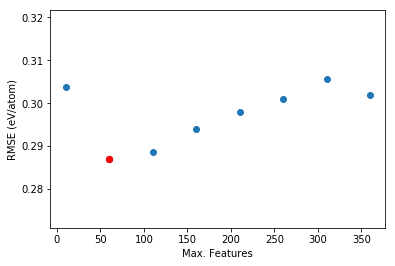

In [35]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

In [36]:
model = model.best_estimator_

Cross validated prediction of training, validation and testing sets.

In [37]:
cv_train = cross_val_predict(model, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(model, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(model, x_test, y_test, cv=kfold)

Plot the prediction of total energy

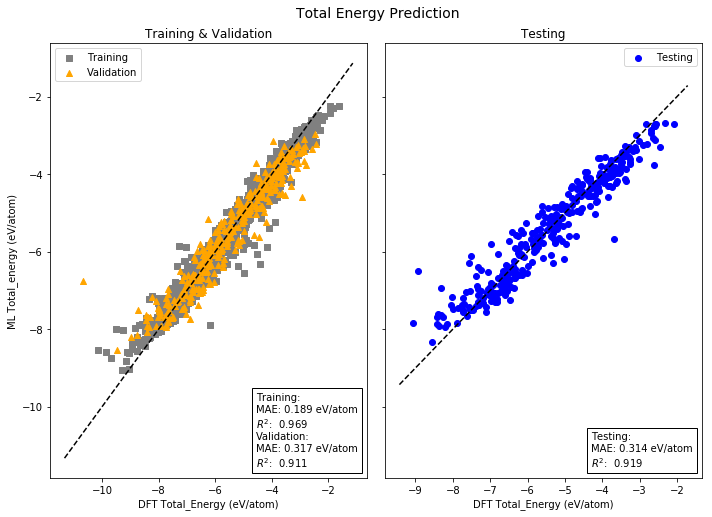

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Total Energy Prediction', fontsize=14, x=0.53, y=1.02)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Total_Energy (eV/atom)')
ax1.set_ylabel('ML Total_energy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Total_Energy (eV/atom)')

fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

### Prediction of formation enthalpy

In [39]:
ML_delta_e = pd.Series(index=np.arange(data.shape[0]))

In [40]:
ML_total_energy = model.predict(x)

Importing fitted elemental phase reference energies, $\mu^{FERE}$ from `matminer.utils.data_files.deml_elementdata`

In [41]:
from matminer.utils.data_files.deml_elementdata import mus_fere

Using total energy value to compute formation energy according to the equation 
$$\Delta H_f = E_{tot} - \Sigma_i c_i \mu_i^{FERE}$$

In [42]:
for i in range(data.shape[0]):
    fere = (float(data['composition_obj'][i][str(j)])/data['composition_obj'][i].num_atoms*mus_fere[str(j)] for j in (data['composition_obj'][i]))
    fere = sum(fere)
    ML_delta_e[i] = ML_total_energy[i] - fere

Partitioning both ML and DFT formation enthalpy data into training, validation and testing sets.

In [43]:
DFT_delta_e = orig_delta_e
ML_delta_e, DFT_delta_e = shuffle(ML_delta_e, DFT_delta_e)
dft_train, dft_val, dft_test = DFT_delta_e[:int(n*0.7)], DFT_delta_e[int(n*0.7):int(n*0.85)], DFT_delta_e[int(n*0.85):]
ml_train, ml_val, ml_test = ML_delta_e[:int(n*0.7)], ML_delta_e[int(n*0.7):int(n*0.85)], ML_delta_e[int(n*0.85):]

Plot the prediction of formation enthalpy

In [44]:
mae_train = metrics.mean_absolute_error(ml_train, dft_train)
mae_val = metrics.mean_absolute_error(ml_val, dft_val)
mae_test = metrics.mean_absolute_error(ml_test, dft_test)

r2_train = metrics.r2_score(ml_train, dft_train)
r2_val = metrics.r2_score(ml_val, dft_val)
r2_test = metrics.r2_score(ml_test, dft_test)

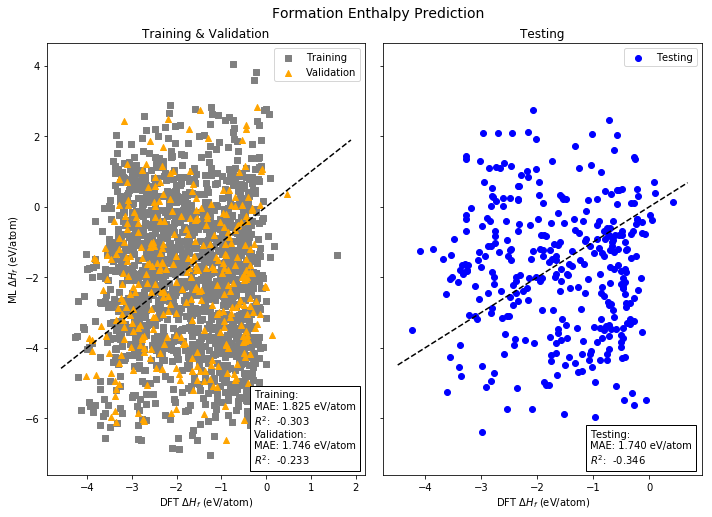

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Formation Enthalpy Prediction', fontsize=14, x=0.53, y=1.02)

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax1.set_ylabel('ML $\Delta H_f$ (eV/atom)')
ax1.scatter(dft_train, ml_train, c='grey', marker='s', label='Training')
ax1.scatter(dft_val, ml_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax2.scatter(dft_test, ml_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.legend()

fig.set_size_inches(10, 7)
fig.tight_layout()

## PREDICTION OF FORMATION ENTHALPY DIRECTLY (RandomForest)

In [46]:
data = shuffle(data)

In [47]:
x = data.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y = data['delta_e']

Dividing datasets into training, validation and testing sets

In [48]:
n = data.shape[0]
x_train, x_val, x_test = x[:int(n*0.7)], x[int(n*0.7):int(n*0.85)], x[int(n*0.85):]
y_train, y_val, y_test = y[:int(n*0.7)], y[int(n*0.7):int(n*0.85)], y[int(n*0.85):]

Using GridSearchCV to find the optimal number of features. 

In [49]:
model = GridSearchCV(RandomForestRegressor(n_estimators=100),
                     param_grid=dict(max_features=range(10, data.shape[1], 50)),
                     scoring='neg_mean_squared_error', 
                     cv=kfold)

In [50]:
%%time
model.fit(x_train, y_train)

CPU times: user 11min 28s, sys: 5.27 s, total: 11min 33s
Wall time: 11min 51s


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(10, 370, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Plot RMSE as a function of features used

Text(0,0.5,'RMSE (eV/atom)')

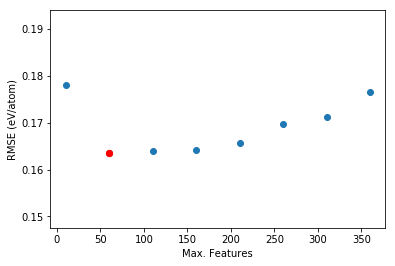

In [51]:
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

In [52]:
model = model.best_estimator_

Cross validated prediction of training, validation and testing sets.

In [53]:
cv_train = cross_val_predict(model, x_train, y_train, cv=kfold) 
cv_val = cross_val_predict(model, x_val, y_val, cv=kfold)
cv_test = cross_val_predict(model, x_test, y_test, cv=kfold)

Plot the predictions

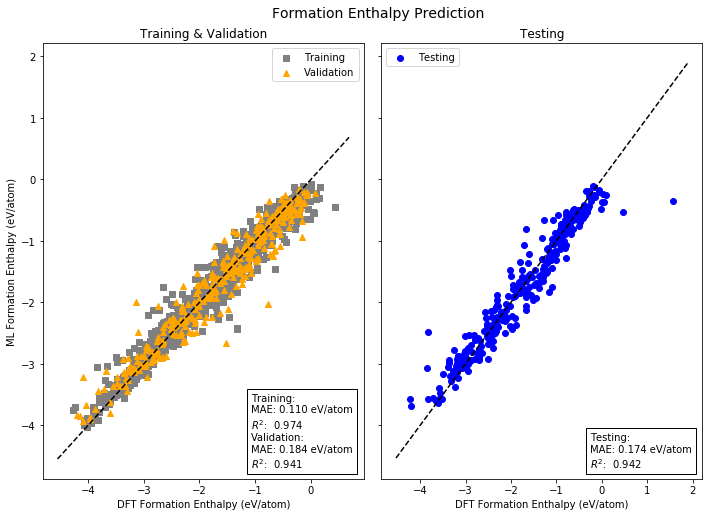

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)

fig.suptitle('Formation Enthalpy Prediction', fontsize=14, x=0.53, y=1.02)

# Training and Validation plot
mae_train = metrics.mean_absolute_error(y_train, cv_train)
r2_train = metrics.r2_score(y_train, cv_train)
mae_val = metrics.mean_absolute_error(y_val, cv_val)
r2_val = metrics.r2_score(y_val, cv_val)
ax1.text(0.65, 0.026, 'Training:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}\nValidation:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_train, r2_train, mae_val, r2_val),
        transform=ax1.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax1.scatter(y_train, cv_train, c='grey', marker='s', label='Training')
ax1.scatter(y_val, cv_val, c='orange', marker='^', label='Validation')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.legend()

ax1.set_title('Training & Validation')
ax1.set_xlabel('DFT Formation Enthalpy (eV/atom)')
ax1.set_ylabel('ML Formation Enthalpy (eV/atom)')

# Testing plot
mae_test = metrics.mean_absolute_error(y_test, cv_test)
r2_test = metrics.r2_score(y_test, cv_test)
ax2.text(0.65, 0.026, 'Testing:\nMAE: {:.3f} eV/atom\n$R^2$:  {:.3f}'.format(mae_test, r2_test),
        transform=ax2.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.scatter(y_test, cv_test, c='b', marker='o', label='Testing')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax2.legend()

ax2.set_title('Testing')
ax2.set_xlabel('DFT Formation Enthalpy (eV/atom)')

fig.set_size_inches(10, 7)
fig.subplots_adjust(hspace=0)
fig.tight_layout()

*Finding*: Direct prediction of formation enthalpy is much better. There is a mean absolute error of ~170 meV/atom. 